In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import os
import fpfs
import galsim
import numpy as np
import matplotlib.pylab as plt

In [2]:
class LensTransform1(object):
    def __init__(self, gamma1, gamma2, kappa):
        """Initialize the transform object of 2D grids
        Args:
            gamma1 (float):     the first component of lensing shear field
            gamma2 (float):     the second component of lensing shear field
            kappa (float):      the lensing convergence field
        """
        self.s2l_mat = np.array(
            [
                [1 - kappa - gamma1, -gamma2], 
                [-gamma2, 1 - kappa + gamma1]
            ]
        )
        return
    
    def transform(self, coords):
        """transform the center of pixels from lensed plane to pre-lensed plane
        Args:
            coords:   coordinates (x, y) of the pixel centers [arcsec]
        """
        return self.s2l_mat @ coords

In [18]:
class LensTransform2(object):
    def __init__(self, gamma1, gamma2, kappa, F1=0, F2=0, G1=0, G2=0):
        """Initialize the transform object of 2D grids
        Args:
            gamma1 (float):     the first component of lensing shear field
            gamma2 (float):     the second component of lensing shear field
            kappa (float):      the lensing convergence field
        """
        self.s2l_mat = np.array(
            [[1 - kappa - gamma1, -gamma2], [-gamma2, 1 - kappa + gamma1]]
        )
        D1 = -1/2*np.array([[3*F1+G1,F2+G2],[F2+G2,F1-G1]])
        D2 = -1/2*np.array([[F2+G2,F1-G1],[F1-G1,3*F2-G2]])
        self.D = np.stack([D1,D2],axis=2)
        return

    def transform(self, coords):
        """transform the center of pixels from lensed plane to pre-lensed plane
        Args:
            coords:   coordinates (x, y) of the pixel centers [arcsec]
        """
        return self.s2l_mat @ coords + np.einsum('ijk,jl,kl->il',self.D,coords,coords)

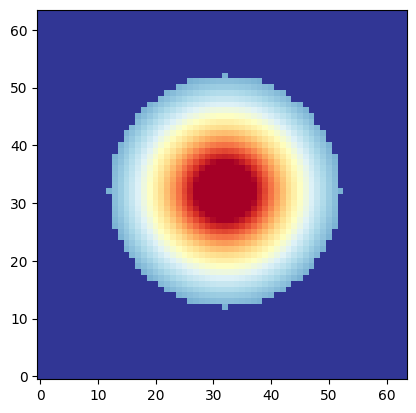

In [19]:
"""Original galaxy"""
flux = 40
scale = 0.2
nn = 64
sersic_gal = galsim.Sersic(n=1.5, half_light_radius=1.5, flux=flux, trunc=4)
stamp = fpfs.simutil.Stamp(nn=nn, scale=scale)
gal_array = stamp.sample_galaxy(sersic_gal)
plt.close()
fpfs.pltutil.make_plot_image(gal_array)

In [20]:
stamp.coords[1,100]

-6.2

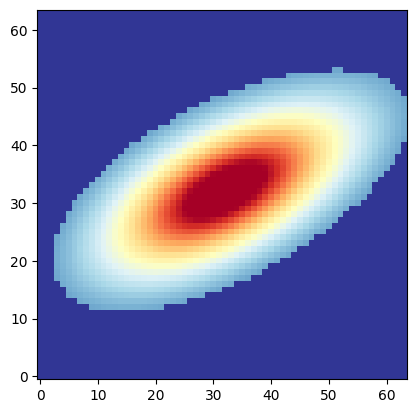

In [35]:
"""Transform then produce image"""
kappa = 0.05
gamma1 = 0.2
gamma2 = 0.3
G1 = 0.003
G2 = 0.0025
F1 = 0.0007
F2 = 0.001
lens = LensTransform2(gamma1=gamma1, gamma2=gamma2, kappa=kappa,F1=F1,F2=F2,G1=G1,G2=G2)

stamp = fpfs.simutil.Stamp(nn=nn, scale=scale)
stamp.transform_grids(lens)
gal_array2 = stamp.sample_galaxy(sersic_gal)
plt.close()
fpfs.pltutil.make_plot_image(gal_array2)

In [48]:
kappa = 0.00
gamma1 = 0.2
gamma2 = 0.3
G1 = 0.003 * 1
G2 = 0.0025 *1
F1 = 0.0007 * 1
F2 = 0.001 * 1
lens = LensTransform2(gamma1=gamma1, gamma2=gamma2, kappa=kappa,F1=F1,F2=F2,G1=G1,G2=G2)
stamp = fpfs.simutil.Stamp(nn=64, scale=scale)
stamp.transform_grids(lens)
gal_array3 = stamp.sample_galaxy(sersic_gal)
psf_array = np.zeros(stamp.shape)
psf_array[nn // 2, nn // 2] = 1

coords = np.array([nn//2, nn//2])
fpTask  =   fpfs.image.measure_source(psf_array, pix_scale = scale, sigma_arcsec=0.52)
mms =  fpTask.measure(gal_array3, coords)
mms = fpTask.get_results(mms)
ells=   fpfs.catalog.fpfs_m2e(mms,const=20)
resp1=np.average(ells['fpfs_R1E'])
shear1=np.average(ells['fpfs_e1'])/resp1
resp2=np.average(ells['fpfs_R2E'])
shear2=np.average(ells['fpfs_e2'])/resp2
print(shear1)
print(shear2)
# print("input shear: %.5f" % gamma1)
# print("measured shear: %.5f" % shear)
"""With gamma =0.2,0.3, the estimation was around 0.20013218952982748 and 0.2919009958423755"""
"""...0.02, 0.03, ...0.02003064723646912 and 0.02998245742260666"""
"""Now adding Flexion with order of magnitude around 0.001, for 0.02, 0.03, we get 0.020032481694420345 and 0.029983423954798905"""
"""Now adding flexion with order of magnitude around 0.01, we get 0.020214244225607216 and 0.030079188989101006"""


"""With gamma =0.2,0.3, and flexion with order around 0.001, the estimation was around 0.20013569976121798 and 0.29190411649459763"""
"""With gamma = 0.2, 0.3 and flexino with order around 0.01, the estimation was around 0.20048144975333682 and 0.29221031487931887"""

2023/09/18 01:09:15 ---  Order of the shear estimator: nnord=4
2023/09/18 01:09:15 ---  Shapelet kernel in configuration space: sigma= 0.5200 arcsec
2023/09/18 01:09:15 ---  Detection kernel in configuration space: sigma= 0.5200 arcsec


0.20013569976121798
0.29190411649459763


'With gamma = 0.2, 0.3 and flexino with order around 0.01, the estimation was around 0.20048144975333682 and 0.29221031487931887'